# Finance Data Analysis
Roberto Garbarino

This Project will be built upon the analysis of the Finance Data Dataset found [here](https://www.kaggle.com/cnic92/200-financial-indicators-of-us-stocks-20142018) 

This Dataset Contains over 200 Financial indicators of US Stocks.
The main goal will is to be able to predict a positive or a negative outlook for a single stock based on this data.
The last column of the dataset represent the class of each stock, where:

 - if the value of a stock increases at the end of the next year, then class=1;
 - if the value of a stock decreases at the end of the next year, then class=0.

## 0 - Imports

In [3]:
##Math and data manipulation
import numpy as np
import pandas as pd
import scipy

##ML imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

##Plotting Imports & Settings
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5 ##This makes the plots bigger
import sys
np.set_printoptions(threshold=sys.maxsize)

## 1 - Data Analysis and Exploration

Let's open our dataset using Pandas.

In [4]:
D2014 = pd.read_csv('2014_Financial_Data.csv')

### A first Look to the Data

Let's take a first look at our data.

In [5]:
df = D2014.copy()
df.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2015 PRICE VAR [%],Class
0,PG,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,...,-0.0187,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,-9.323276,0
1,VIPS,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,NaN,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,-25.512193,0
2,KR,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,...,0.0618,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,33.118297,1
3,RAD,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,...,0.0211,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,2.752291,1
4,GIS,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,...,0.0257,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,12.897715,1


Let's remove the name column and PRICE VAR [%] column. We need to remove this last column since it's an indicator of the next year trend, and in a general context, this information isn't available to us.

In [6]:
df = df.loc[:, df.columns != 'Unnamed: 0']
df = df.loc[:, df.columns != '2015 PRICE VAR [%]']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 223 entries, Revenue to Class
dtypes: float64(221), int64(1), object(1)
memory usage: 6.5+ MB


In [7]:
##Let's Save The Y column
df_Y = df['Class']

As we can see, we have 1 object column which is a categorical column, the sector on which the company operates.

To train our model we have to change this categorical column from a string one into a numeric one.
Let's define a function to do that.

In [8]:
def normalize_sector(dataset):    
    count = 1
    dic = {}
    for elem in dataset.Sector:
        if elem not in dic:
            dic[elem] = str(count)
            count += 1

    for elem in dic.items():
        dataset.loc[dataset['Sector'] == elem[0], 'Sector'] = elem[1]
    dataset['Sector'] = dataset['Sector'].astype('int')

In [9]:
normalize_sector(df)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Columns: 223 entries, Revenue to Class
dtypes: float64(221), int32(1), int64(1)
memory usage: 6.5 MB


In [11]:
df.Sector.head()

0    1
1    1
2    1
3    1
4    1
Name: Sector, dtype: int32

We have successfully modified the `Sector` column.

Let's now look at the class balance in the dataset.

The number of zeros is 2174 and the number of ones is 1634


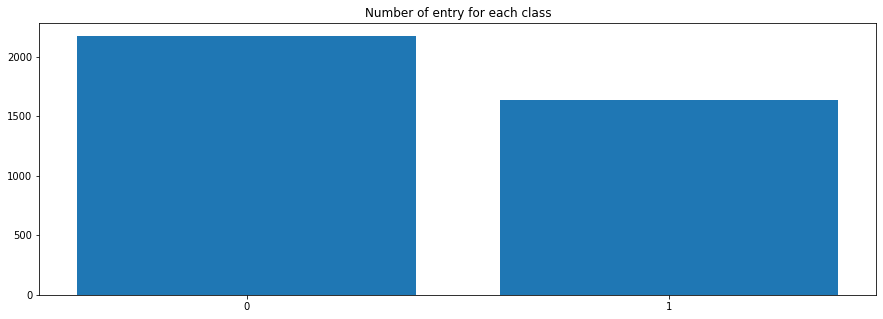

In [12]:
classes = df['Class'].to_numpy()
zeros = len(classes[classes == 0])
ones = len(classes[classes == 1])
plt.bar([0, 1], [zeros, ones])
plt.title('Number of entry for each class')
plt.xticks([0, 1], ['0', '1'])

print('The number of zeros is', zeros, 'and the number of ones is', ones)

So we have that the dataset is not balanced, but we are going to address this problem later in the notebook.

### Missing Values and Zero-Values

Let's move on and address the missing values in the dataset.

First let's see how many missing values we have

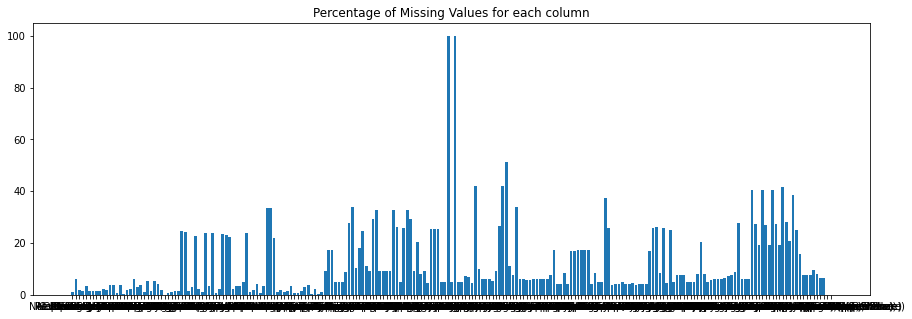

In [13]:
nan_val = df.isna().sum()
nan_perc = 100 * nan_val / df.shape[0]
plt.title('Percentage of Missing Values for each column')
plt.bar(df.keys(), nan_perc)
plt.show()

We have a lot of missing value, for some column almost 100% of its entries are NaN values. A good start could be to define a threshold of missing value of a column over which we completely drop it.
Let's drop a column if it has more than 7% of missing data.

In [14]:
thresh = df.shape[0] - df.shape[0]*0.07
df = df.dropna(thresh = thresh, axis=1)

Let's now look at the zero values in each column

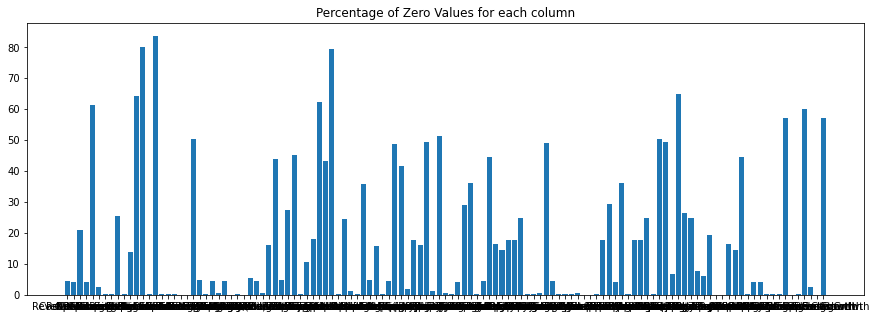

In [15]:
zero_val = df.isin([0]).sum()
zero_perc = 100 * zero_val / df.shape[0]
plt.title('Percentage of Zero Values for each column')
plt.bar(df.keys(), zero_perc)
plt.show()

We have a lot of zero values, some column are zero for almost every entry. As before, let's define a threshold for zero values, at 10%.

In [16]:
thresh = df.shape[0]-df.shape[0] * 0.9
df = df.loc[:, (df.isin([0]).sum(axis=0) <= thresh)]

And Finally let's visualize the changes.

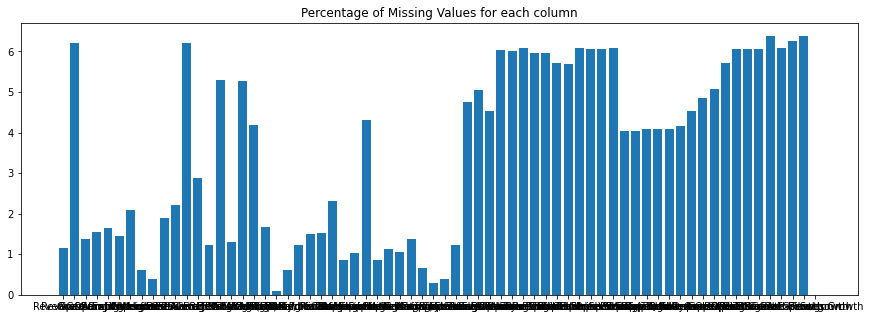

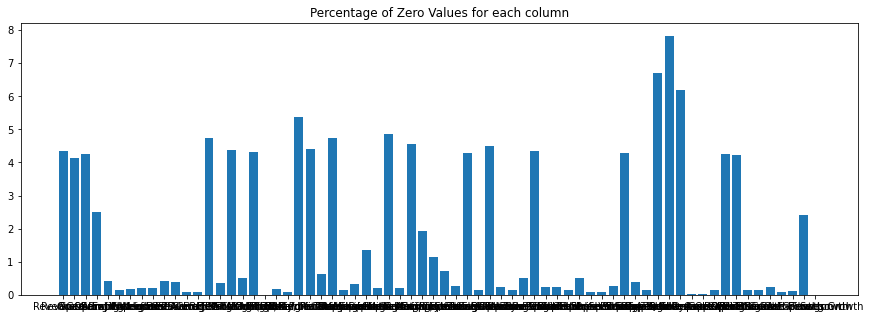

The shape of our Dataset after these changes is  (3808, 68)


In [17]:
nan_val = df.isna().sum()
nan_perc = 100 * nan_val / df.shape[0]
plt.title('Percentage of Missing Values for each column')
plt.bar(df.keys(), nan_perc)
plt.show()

zero_val = df.isin([0]).sum()
zero_perc = 100 * zero_val / df.shape[0]
plt.title('Percentage of Zero Values for each column')
plt.bar(df.keys(), zero_perc)
plt.show()

print('The shape of our Dataset after these changes is ', df.shape)

We have removed more than 150 features. This will help us to save time in the training of our model, and will also reduce the variance over our future estimates.

### Imputing missing values and Final Touches to the dataset

Let's now divide X and Y (Y is the `Class` column we saved before) for training purposes. We also want to change the values of Y to 1 and -1, to remain coherent with our theoretical background.

In [18]:
Y = df_Y.to_numpy()
X = df.to_numpy()
Y[Y==0] = -1

We have removed the column where we had the most missing values, but we have not removed all of them.

To fill the missing data we can apply different strategies
 - fill them with zeros
 - fill them with the mean of the column
 - fill them with the median of the column
 - fill them with a constant number
 
In this case I decided to fill them with the mean of the whole column, using the `SimpleImputer` class from `sklearn` 

In [19]:
imputer = SimpleImputer(strategy = 'mean')
imputer.fit(X)
X = imputer.transform(X)

Lastly, let's define the classic error function needed.

In [2]:
def calcError(Ypred, Y): 
    V=np.multiply(np.sign(Ypred),np.sign(Y) )
    return np.count_nonzero(V<0)/len(Y)

## 2 - Binary Classification with Support Vector Machines

Let's proceed with our machine learning task.
We will use **Support Vector Machines**. I believe that this is one of the best method since we have an unbalanced dataset and using SVMs we can easily define weights for our classes.
To accomplish this we are going to use the `SVC` class defined in the `sklearn` package.

Let's start by dividing the data into training and test (with 70% of Samples going to the training set) using the `train_test_split` function. Here we need to use the stratify parameter to ensure that the relative class frequencies are preserved when splitting the data.

In [21]:
Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state = 42, stratify = Y)

norm = np.linalg.norm(Xtr, axis = 0)
Xtrnorm = Xtr/norm
Xtenorm = Xte/norm

Let's take a look at the **Support Vector Classifier**. Another advantage of using SVMs is that we can natively define a kernel in the sklearn method.
We have the support of 4 different kernels:
 - *RBF* (Or *Gaussian Kernel*)
 - *Linear*
 - *Sigmoid*
 - *Polynomial*
 
We have to choose `gamma` parameter for the RBF, Sigmoid and Polynomial kernels, and the `degree` parameter only for the polynomial one.
Support Vector Machines are also defined by the *slack* variable, defined as `C` in the `SVC` class. The slack variable represents how many samples we can allow to be misclassified.

To rebalance the dataset, we can set weights to each class by setting the `class_weight` option on `balanced`


In [22]:
svm = SVC(class_weight = 'balanced') 
svm.fit(Xtrnorm, Ytr)
Ypred = svm.predict(Xtenorm)
print('The error on our test set using SVC with RBF Kernel is', calcError(Ypred, Yte))
Ypred = svm.predict(Xtrnorm)
print('The error on our training set using SVC with RBF Kernel is', calcError(Ypred, Ytr))

The error on our test set using SVC with RBF Kernel is 0.3963254593175853
The error on our training set using SVC with RBF Kernel is 0.3952724885095207


But the prediction is critical to the choiche of `C`, `gamma`(eventually `degree`) and the underlying kernel. To decide which parameters are better we use `GridSearchCV`, to test every combination using **Cross Validation** with 5 folds.

This function takes a list of dictionaries as a parameter, where each dictionary define all the possible values for each kernel.

In [21]:
params = [
    {'C': [0.1, 1, 10, 20, 50, 100, 200], 'gamma': [30, 40, 50, 100, 200, 300, 400, 600, 1000, 1,1.1,1.2,0.1,0.01,0.001],'kernel': ['rbf']},
    {'C': [0.1, 1, 10, 20, 50, 100, 200], 'kernel': ['linear']},
    {'C': [0.1, 1, 10, 20, 50, 100, 200], 'gamma': [30, 40, 50, 100, 200, 300, 400, 600, 1000, 1,1.1,1.2,0.1,0.01,0.001],'degree': [1,2,3,4,5,6], 'kernel' : ['poly']},
    {'C': [0.1, 1, 10, 20, 50, 100, 200],'kernel': ['sigmoid']}
]
grid = GridSearchCV(SVC(class_weight = 'balanced'), params)
grid.fit(Xtrnorm, Ytr)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid=[{'C': [0.1, 1, 10, 20, 50, 100, 200],
                          'gamma': [30, 40, 50, 100, 200, 300, 400, 600, 1000,
                                    1, 1.1, 1.2, 0.1, 0.01, 0.001],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 20, 50, 100, 200],
                          'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 20, 50, 100, 200],
                          'degree': [1, 2, 3, 4, 5, 6],
                          'gamma': [30, 40, 50, 100, 200, 300, 400, 600, 1000,
                                    1, 1.1, 1.2, 0.1, 0.01, 0.001],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 10, 20, 50, 100, 200],
                          'gamma': [30, 40, 50, 100, 200, 300, 400, 600, 1000,
                                    1, 1.1, 1.2, 0.1, 0.01, 0.001],
                          'kernel': ['sigmoid']}])

In [57]:
print('The best estimator found using CV is', grid.best_estimator_)
YpredTr = grid.predict(Xtrnorm) 
YpredTe = grid.predict(Xtenorm)
print('The Training error is', calcError(YpredTr, Ytr))
print('The Test error is', calcError(YpredTe, Yte))

The best estimator found using CV is SVC(C=1, class_weight='balanced', degree=2, gamma=600, kernel='poly')
The Training error is 0.3479973736047275
The Test error is 0.3910761154855643


Our Prediction got Slightly Better.

The relatively small difference between the training and test error means that our model is in that sweet spot of balance in the Bias-Variance Tradeoff.

## 3 - Variable Selection

We are now going to apply **Orthogonal Matching Pursuit** to find the most relevant Variables in our Dataset.

In [23]:
def KFoldCVOMP(Xtr, Ytr, KF, niter_list):

    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    niter_list = np.array(niter_list)
    num_niter = niter_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.floor(n_tot/KF))

    Tm = np.zeros(num_niter)
    Ts = np.zeros(num_niter)
    Vm = np.zeros(num_niter)
    Vs = np.zeros(num_niter)

    # Random permutation of training data
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    
    
    for kdx, niter in enumerate(niter_list):
        first = 0
        for fold in range(KF):
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1;
            
            X = Xtr[rand_idx[flags==0]]
            Y = Ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            Y_val = Ytr[rand_idx[flags==1]]

            # Compute the training error of OMP for the given number of iterations
            w, r, I = OMatchingPursuit(X, Y, niter)
            YpredTR = np.sign(X.dot(w))
            trError = calcError(YpredTR, Y)
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # Compute the validation error OMP for the given number of iterations
            YpredVAL = np.sign(X_val.dot(w))
            valError = calcError(YpredVAL, Y_val)
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2
            
            first = first+n_val                

    Tm = Tm / KF
    Ts = Ts / KF - Tm ** 2

    Vm = Vm / KF
    Vs = Vs / KF - Vm ** 2

    best_niter_idx = np.argmin(Vm)
    bestniter = niter_list[best_niter_idx]
    
    print(Vm)
    print(niter_list)
    print(best_niter_idx)

    return bestniter, Vm, Vs, Tm, Ts

In [24]:
def OMatchingPursuit(X, Y, T):

    N, D = np.shape(X)

    # Initialization of residual, coefficient vector and index set I
    r = Y
    w = np.zeros(D)
    I = []

    for i in range(T):
        I_tmp = range(D)

        # Select the column of X which coefficients most "explains" the residual
        a_max = -1

        for j in I_tmp:
            a_tmp = (r.T@X[:,j])**2/(np.dot(X[:,j],X[:,j].T)) 

            if a_tmp > a_max:
                a_max = a_tmp
                j_max = j

        # Add the index to the set of indexes
        if np.sum(I == j_max) == 0:
            I.append(j_max)

        # Compute the M matrix
        M_I = np.zeros((D, D))

        for j in I:
            M_I[j, j] = 1

        A = M_I.dot(X.T).dot(X).dot(M_I)
        B = M_I.dot(X.T).dot(Y)

        # Update estimated coefficients
        w = np.linalg.pinv(A)@B

        # Update the residual
        r = Y - X@w

    return w, r, I

Let's use **Cross Validation** with 5 folds to find the best number of iterations for our OMP Algorithm.

[0.42167488 0.42889984 0.43546798 0.43481117 0.43021346 0.43546798
 0.4407225  0.4407225  0.43842365 0.43678161 0.43776683 0.43743842
 0.43546798 0.4364532  0.43448276 0.43415435 0.43513957 0.43546798
 0.43579639 0.43448276 0.43809524 0.43875205 0.43842365 0.43743842
 0.43678161 0.43481117 0.43842365 0.43743842 0.43711002 0.43546798
 0.43546798 0.43612479 0.43579639 0.43448276 0.43415435 0.43579639
 0.43678161 0.43382594 0.43448276 0.43415435 0.43546798 0.43513957
 0.43415435 0.43875205 0.43678161 0.43579639 0.43711002 0.4364532
 0.43842365 0.43809524 0.43776683 0.43743842 0.43842365 0.43809524
 0.43612479 0.43612479 0.43612479 0.43415435 0.42988506 0.43021346
 0.43087028 0.42922824 0.42889984 0.43021346 0.43119869 0.42758621
 0.42758621]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
0
Best number of iterations: 1


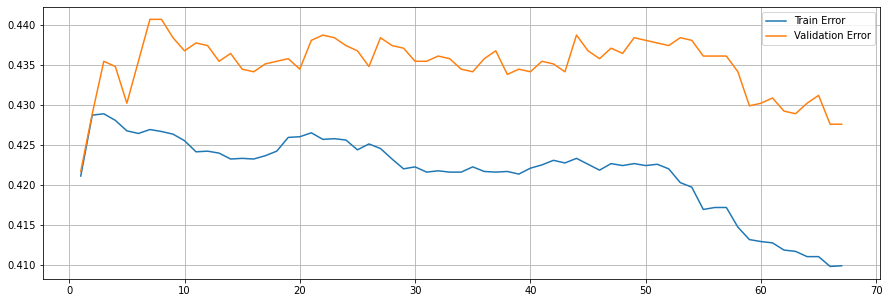

In [25]:
KF = 5
niter_list = np.arange(1, Xtr.shape[1])
bestniter, Vm, Vs, Tm, Ts = KFoldCVOMP(Xtrnorm, Ytr, KF, niter_list)

plt.subplots()
plt.plot(niter_list, Tm, label = 'Train Error')
plt.plot(niter_list, Vm, label = 'Validation Error')
plt.grid()
plt.legend(loc = 'best')
print('Best number of iterations: '+str(bestniter))

In [26]:
w, r, I = OMatchingPursuit(Xtrnorm, Ytr, 1)
YpredTe = np.sign(Xtenorm.dot(w))

teError = calcError(YpredTe, Yte)
print('The test Error is', teError)
print('The number of relevant features with', bestniter, 'iterations is',len(I), 'and are', I)


The test Error is 0.41732283464566927
The number of relevant features with 1 iterations is 1 and are [38]


So we found that the most relevant feature is 

In [27]:
print(df.columns[I])

Index(['assetTurnover'], dtype='object')


But what is the **Asset Turnover**?

According to [investopedia](https://www.investopedia.com/terms/a/assetturnover.asp), "The asset turnover ratio measures the value of a company's sales or revenues relative to the value of its assets. The asset turnover ratio can be used as an indicator of the efficiency with which a company is using its assets to generate revenue.", so it makes sense for it to be that important.

Let's now see the 10 most relevant features.

In [28]:
w, r, I = OMatchingPursuit(Xtrnorm, Ytr, 1)
print(df.columns[I])

Index(['assetTurnover'], dtype='object')


Let's take a look and see whether these results make sense. Honestly it's pretty difficult to find a consensus over which financial indicator is better, but we'll try our best.

According to [this](https://www.investopedia.com/articles/fundamental-analysis/09/five-must-have-metrics-value-investors.asp#free-cash-flow) article by investopedia, we have that the 2 out of the 5 metrics listed here are present in our results (*Free Cash Flow* and *P/E Ratio*, in the form of *Earnings Yield*). We also have a general agreement ([here](https://www.investopedia.com/financial-edge/0910/6-basic-financial-ratios-and-what-they-tell-you.aspx) [here](https://www.fool.com/investing/2018/03/21/9-essential-metrics-all-smart-investors-should-kno.aspx) [here](https://www.investopedia.com/articles/investing/061916/what-best-measure-companys-financial-health.asp)
[here](https://www.washingtonpost.com/blogs/on-small-business/post/5-financial-metrics-you-should-know/2012/05/25/gJQAuDSjpU_blog.html)) That the *Net Income per Share* and *Earning Before Tax Margin* are pretty important indicators.

## 4 - Conclusions



Our Task was a pretty difficult one. We had a dataset with a whole bunch of problems (missing data, column almost completely filled with zeros, unbalanced classes) and we tried to meddle with all of those.
We defined our problem as a binary classification one, and we used Support Vector Machines to solve it. We also had to deal with a really high complexity for the Cross Validation function since we had a lot of different parameters to choose from. 
We then proceeded to look at the most relevant features with matching pursuit to find that our results weren't so far from reality.

The results weren't actually perfect, especially in the classification part,  but I still believe it was really useful to learn how to deal with a real problem with a real dataset of appropriate complexity and to learn more about Support Vector Machines and the kernels that we can use with it.